In [4]:
import os
import cv2
import dlib
import numpy as np
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity

BASE_FOLDER=os.getcwd()
INFLUENCER_FACE_DATA = BASE_FOLDER+"/influencer_face_data"
UNIQUE_INFLUENCER_FACE_DATA = BASE_FOLDER+"/unique_influencer_face_data"
FACE_IMG_FOLDER = os.path.join(INFLUENCER_FACE_DATA, "face_img")
FACE_SCORE_FOLDER = os.path.join(INFLUENCER_FACE_DATA, "face_score")
UNIQUE_FACE_IMG_FOLDER = os.path.join(UNIQUE_INFLUENCER_FACE_DATA, "face_img")
UNIQUE_FACE_SCORE_FOLDER = os.path.join(UNIQUE_INFLUENCER_FACE_DATA, "face_score")

os.makedirs(UNIQUE_FACE_IMG_FOLDER, exist_ok=True)
os.makedirs(UNIQUE_FACE_SCORE_FOLDER, exist_ok=True)

face_detector = dlib.get_frontal_face_detector()
shape_predictor_path = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
face_rec_model = dlib.face_recognition_model_v1("dlib_face_recognition_resnet_model_v1.dat")

def get_face_embedding(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray, 1)

    if len(faces) == 0:
        return None

    face = faces[0]
    shape = shape_predictor_path(img, face)
    face_embedding = np.array(face_rec_model.compute_face_descriptor(img, shape))
    return face_embedding

def process_faces():
    processed_embeddings = []
    unique_faces = {}

    for img_file in os.listdir(FACE_IMG_FOLDER):
        img_path = os.path.join(FACE_IMG_FOLDER, img_file)
        score_file = os.path.join(FACE_SCORE_FOLDER, f"{Path(img_file).stem}.txt")

        if not os.path.exists(score_file):
            print(f"Missing score file for {img_file}, skipping.")
            continue

        with open(score_file, "r") as sf:
            score = float(sf.read().strip())

        face_embedding = get_face_embedding(img_path)
        if face_embedding is None:
            print(f"Failed to extract face embedding for {img_file}, skipping.")
            continue


        is_unique = True
        for idx, emb in enumerate(processed_embeddings):
            similarity = cosine_similarity([face_embedding], [emb])[0][0]
            if similarity > 0.93:
                is_unique = False
                unique_faces[idx]["scores"].append(score)
                unique_faces[idx]["sources"].append(img_file)
                break

        if is_unique:
            processed_embeddings.append(face_embedding)
            unique_faces[len(processed_embeddings) - 1] = {
                "image_path": img_path,
                "scores": [score],
                "sources": [img_file],
            }

    for idx, face_data in unique_faces.items():
        avg_score = sum(face_data["scores"]) / len(face_data["scores"])
        unique_img_name = f"unique_face_{idx}.jpg"
        unique_img_path = os.path.join(UNIQUE_FACE_IMG_FOLDER, unique_img_name)
        unique_score_path = os.path.join(UNIQUE_FACE_SCORE_FOLDER, f"unique_face_{idx}.txt")

        img = cv2.imread(face_data["image_path"])
        cv2.imwrite(unique_img_path, img)

        with open(unique_score_path, "w") as sf:
            sf.write(f"Average Score: {avg_score}\n")
            sf.write("Sources:\n")
            sf.write("\n".join(face_data["sources"]))

    print("Unique face processing completed!")

# Run the process
process_faces()


Failed to extract face embedding for hd-992418235673669_frame310_face12.jpg, skipping.
Failed to extract face embedding for hd-960884234555681_frame160_face23.jpg, skipping.
Failed to extract face embedding for hd-992418235673669_frame290_face10.jpg, skipping.
Failed to extract face embedding for hd-888062106715252_frame310_face11.jpg, skipping.
Failed to extract face embedding for hd-876121221160846_frame320_face16.jpg, skipping.
Failed to extract face embedding for hd-905739711170399_frame320_face7.jpg, skipping.
Failed to extract face embedding for hd-876239523982490_frame620_face12.jpg, skipping.
Failed to extract face embedding for hd-954832972830686_frame110_face18.jpg, skipping.
Failed to extract face embedding for hd-992418235673669_frame580_face14.jpg, skipping.
Failed to extract face embedding for hd-6720438181324436_frame180_face3.jpg, skipping.
Failed to extract face embedding for hd-6764280623620361_frame360_face31.jpg, skipping.
Failed to extract face embedding for hd-876

Top 5 Influencers:
1. unique_face_37 - Average Score: 0.747706
   Sources: hd-874864704574925_frame80_face9.jpg, hd-874864704574925_frame70_face7.jpg, hd-874864704574925_frame60_face6.jpg
2. unique_face_22 - Average Score: 0.747706
   Sources: hd-874864704574925_frame20_face1.jpg, hd-874864704574925_frame10_face0.jpg
3. unique_face_15 - Average Score: 0.720183
   Sources: hd-881342303358042_frame130_face12.jpg, hd-881342303358042_frame20_face1.jpg, hd-881342303358042_frame30_face2.jpg, hd-881342303358042_frame70_face6.jpg, hd-881342303358042_frame40_face3.jpg, hd-881342303358042_frame10_face0.jpg, hd-881342303358042_frame100_face9.jpg, hd-881342303358042_frame50_face4.jpg, hd-881342303358042_frame120_face11.jpg, hd-881342303358042_frame90_face8.jpg, hd-881342303358042_frame80_face7.jpg, hd-881342303358042_frame60_face5.jpg, hd-881342303358042_frame110_face10.jpg
4. unique_face_41 - Average Score: 0.706422
   Sources: hd-6720438181324436_frame210_face4.jpg
5. unique_face_0 - Average Sco

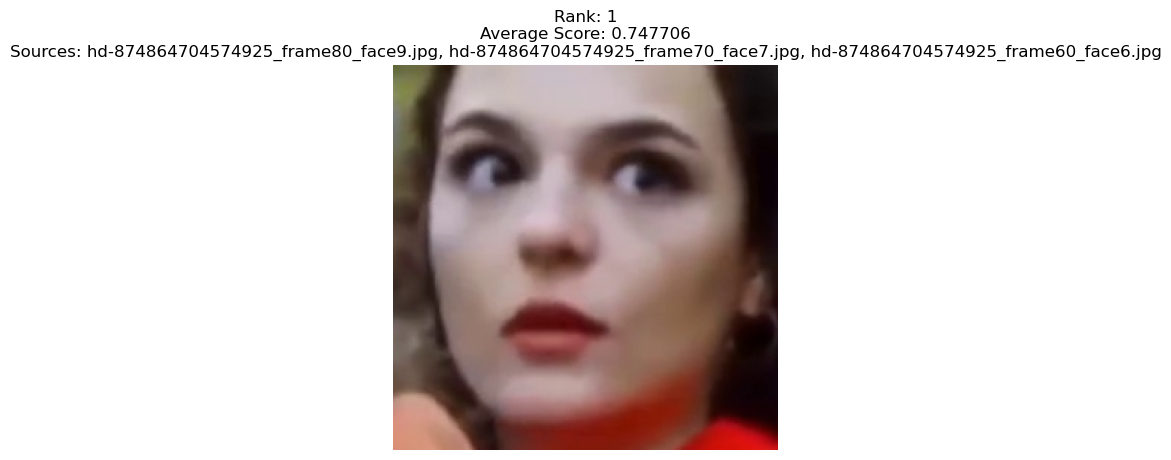

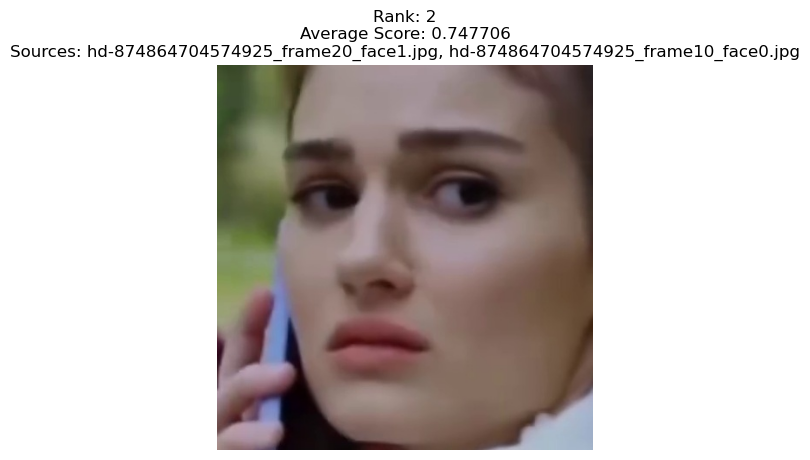

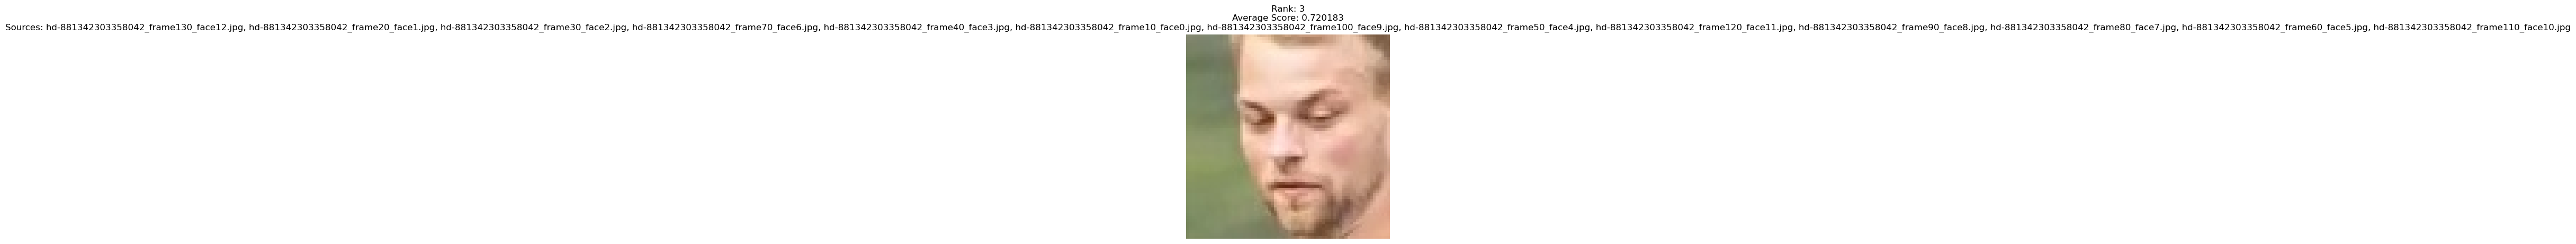

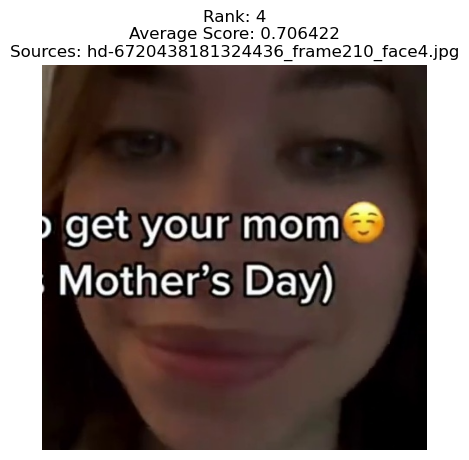

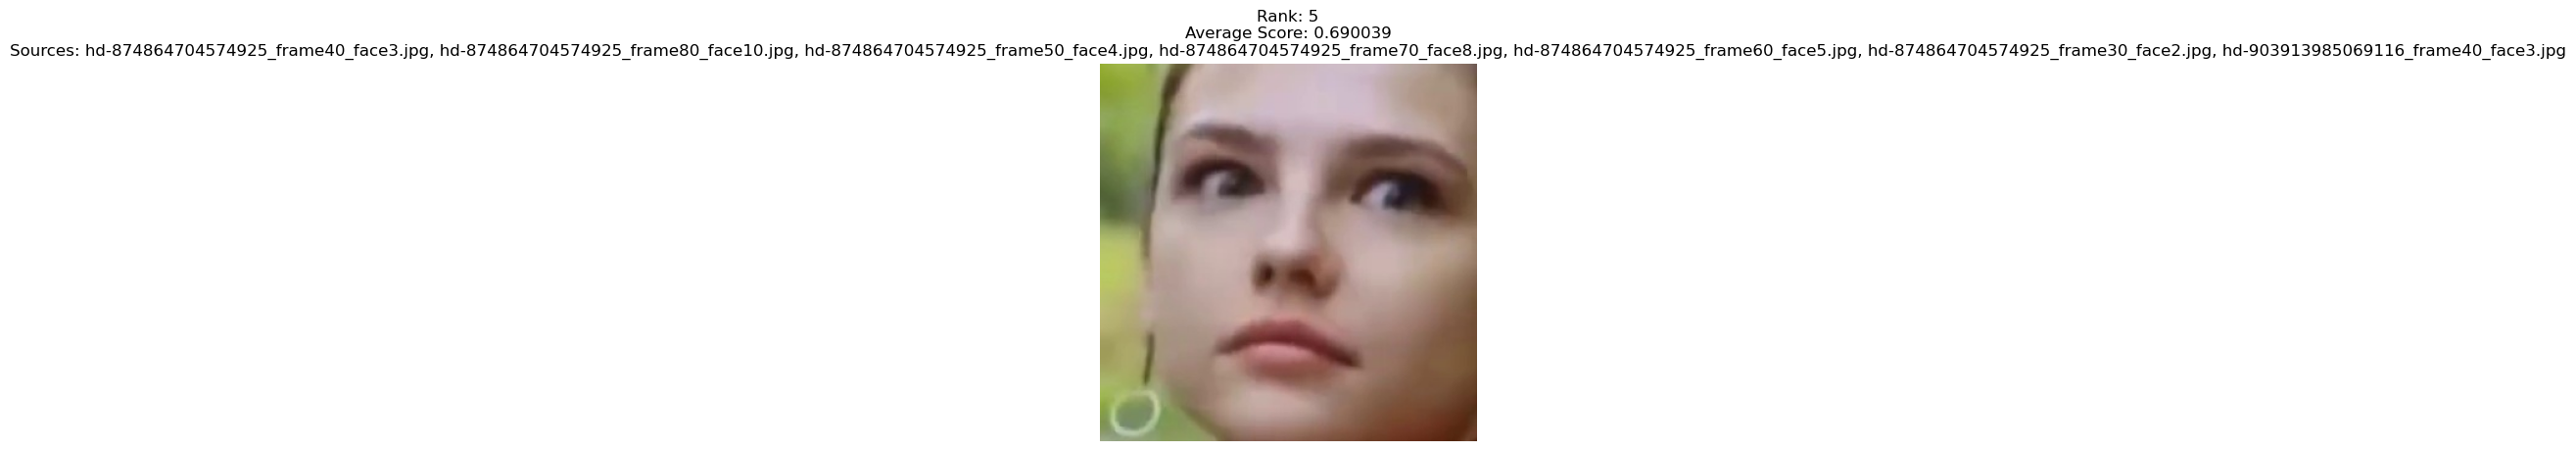

In [3]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

# Paths
UNIQUE_FACE_IMG_FOLDER = "unique_influencer_face_data/face_img"
UNIQUE_FACE_SCORE_FOLDER = "unique_influencer_face_data/face_score"

TOP_N = 5

def get_top_influencers(score_folder, top_n):
    influencer_scores = []

    for score_file in os.listdir(score_folder):
        score_path = os.path.join(score_folder, score_file)
        with open(score_path, "r") as f:
            lines = f.readlines()

            avg_score_line = next(line for line in lines if "Average Score:" in line)
            avg_score = float(avg_score_line.split(":")[1].strip())

            sources_start_idx = lines.index("Sources:\n") + 1
            sources = [line.strip() for line in lines[sources_start_idx:]]

            influencer_scores.append({
                "file": Path(score_file).stem,
                "avg_score": avg_score,
                "sources": sources
            })

    influencer_scores.sort(key=lambda x: x["avg_score"], reverse=True)

    return influencer_scores[:top_n]

def display_influencers(top_influencers, img_folder):
    """
    Displays the top influencers along with their images.
    
    :param top_influencers: List of top influencers with their scores and sources.
    :param img_folder: Path to the folder containing face images.
    """
    for idx, influencer in enumerate(top_influencers, start=1):
        img_path = os.path.join(img_folder, f"{influencer['file']}.jpg")

        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Rank: {idx}\nAverage Score: {influencer['avg_score']}\nSources: {', '.join(influencer['sources'])}")
            plt.show()
        else:
            print(f"Image not found for {influencer['file']}")

def main():
    top_influencers = get_top_influencers(UNIQUE_FACE_SCORE_FOLDER, TOP_N)

    print(f"Top {TOP_N} Influencers:")
    for idx, influencer in enumerate(top_influencers, start=1):
        print(f"{idx}. {influencer['file']} - Average Score: {influencer['avg_score']}")
        print(f"   Sources: {', '.join(influencer['sources'])}")

    display_influencers(top_influencers, UNIQUE_FACE_IMG_FOLDER)

if __name__ == "__main__":
    main()


In [ ]:
import whisper
import os
from transformers import pipeline

def extract_video_content(video_path):
    """
    Extracts textual content from a video using Whisper.

    :param video_path: Path to the video file.
    :return: Transcribed text from the video.
    """
    # Load Whisper model
    model = whisper.load_model("base")  # Use "base" for smaller, faster; "large" for better accuracy

    print(f"Processing video: {video_path}")

    # Transcribe video
    result = model.transcribe(video_path)

    # Return the transcribed text
    return result["text"]

def summarize_text(text, max_length=100):
    """
    Summarizes the given text using a Hugging Face summarization model.

    :param text: The text to summarize.
    :param max_length: Maximum length of the summary.
    :return: Summarized text.
    """
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    summary = summarizer(text, max_length=max_length, min_length=30, do_sample=False)
    return summary[0]["summary_text"]

def analyze_video_with_llm(summary, llm_model=None):
    """
    Passes the summary to an LLM and gets its analysis.

    :param summary: Summarized text from the video.
    :param llm_model: LLM model function (e.g., GPT, local LLM).
    :return: LLM response.
    """
    # For a placeholder, use print statements for demonstration.
    if llm_model:
        return llm_model(summary)
    else:
        print(f"Prompting LLM with the summary:\n{summary}")
        print("\n[LLM]: Why is this video performing well?")
        return "This video is engaging due to its clear visuals and catchy background music."

def main_video_to_text_and_summary(top_influencers, video_folder):
    """
    Extracts, summarizes, and analyzes content from the first source video of each influencer.

    :param top_influencers: List of top influencers with sources.
    :param video_folder: Path to the folder containing the original videos.
    """
    for idx, influencer in enumerate(top_influencers, start=1):
        # Extract the base video name from the face image filename
        first_source_face = influencer['sources'][0]
        video_name = first_source_face.split('_')[0]  # Extract video name, e.g., "hd-874864704574925"
        video_path = os.path.join(video_folder, f"{video_name}")  # Assuming .mp4 extension

        if os.path.exists(video_path):
            print(f"Processing Top Influencer {idx} ({video_name}):")
            
            # Step 1: Extract video transcription
            video_content = extract_video_content(video_path)
            influencer["video_content"] = video_content

            # Step 2: Summarize the transcription
            summary = summarize_text(video_content, max_length=100)
            influencer["summary"] = summary

            # Step 3: Analyze with LLM
            llm_analysis = analyze_video_with_llm(summary)
            influencer["llm_analysis"] = llm_analysis

            # Output results
            print(f"Summary for {video_name}:\n{summary}")
            print(f"LLM Analysis for {video_name}:\n{llm_analysis}")
        else:
            print(f"Video not found: {video_name}")

# Example usage
BASE_FOLDER = os.getcwd()
ORIGINAL_VIDEO_FOLDER = BASE_FOLDER + "/unique_videos"
top_influencers = get_top_influencers(UNIQUE_FACE_SCORE_FOLDER, 5)
main_video_to_text_and_summary(top_influencers, ORIGINAL_VIDEO_FOLDER)


Processing Top Influencer 1 (hd-874864704574925):


/home/vishist/anaconda3/lib/python3.12/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


Processing video: /home/vishist/coding/Startup_Assignments/FuelGrowth/Influencer-Face-Metrics/Jupyter_notebooks/unique_videos/hd-874864704574925


/home/vishist/anaconda3/lib/python3.12/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [5]:
import openai

# Configure the API key if needed; replace with your local Ollama/Mistral settings.
openai.api_base = "http://localhost:11434/v1"

def analyze_video_content(video_content):
    """
    Analyzes video content using an LLM to understand why the video is performing well.

    :param video_content: Transcribed text of the video.
    :return: LLM response analyzing the video content.
    """
    prompt = f"""
    The following is a transcription of a video. Analyze the content and explain why this video might be doing well:
    \n\n{video_content}
    """
    response = openai.ChatCompletion.create(
        model="mistral",
        messages=[
            {"role": "system", "content": "You are an AI specializing in video content analysis."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message['content']

def main_llm_analysis(top_influencers):
    """
    Passes the video content of each top influencer to the LLM for analysis.

    :param top_influencers: List of top influencers with video content.
    """
    for idx, influencer in enumerate(top_influencers, start=1):
        if "video_content" in influencer:
            print(f"\nAnalyzing Video for Top Influencer {idx} ({influencer['file']}):")
            analysis = analyze_video_content(influencer["video_content"])
            print(f"LLM Analysis:\n{analysis}")
            influencer["analysis"] = analysis  # Save analysis for reference
        else:
            print(f"No video content available for influencer {idx} ({influencer['file']}).")

# Example usage
main_llm_analysis(top_influencers)



Analyzing Video for Top Influencer 1 (unique_face_37):


APIRemovedInV1: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742
